## *tobac* Feature Detection Filtering

Often, when detecting features with *tobac*, it is advisable to perform some amount of filtering on the data before feature detection is processed to improve the quality of the features detected. This notebook will demonstrate the affects of the various filtering algorithms built into *tobac* feature detection. 

#### Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tobac
import xarray as xr
import scipy.ndimage
import skimage.morphology

#### Generate Feature Data

Here, we will generate some simple feature data where the features that we want to detect are *higher* values than the surrounding (0).

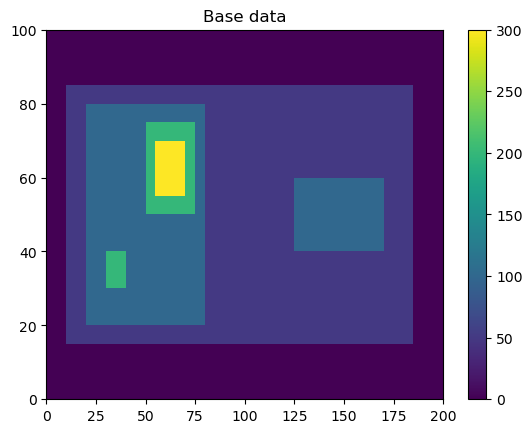

In [2]:
# Dimensions here are time, y, x.
input_field_arr = np.zeros((1, 100, 200))
input_field_arr[0, 15:85, 10:185] = 50
input_field_arr[0, 20:80, 20:80] = 100
input_field_arr[0, 40:60, 125:170] = 100
input_field_arr[0, 30:40, 30:40] = 200
input_field_arr[0, 50:75, 50:75] = 200
input_field_arr[0, 55:70, 55:70] = 300

plt.pcolormesh(input_field_arr[0])
plt.colorbar()
plt.title("Base data")
plt.show()

In [3]:
# We now need to generate an xarray DataArray out of this dataset to run tobac feature detection.
input_field_da = xr.DataArray(
    input_field_arr,
    dims=["time", "Y", "X"],
    coords={"time": [np.datetime64("2019-01-01T00:00:00")]},
)

***

#### Gaussian Filtering (`sigma_threshold` parameter)
First, we will explore the use of Gaussian Filtering by varying the `sigma_threshold` parameter in *tobac*. Note that when we set the `sigma_threshold` high enough, the right feature isn't detected because it doesn't meet the higher `100` threshold; instead it is considered part of the larger parent feature that contains the high feature.

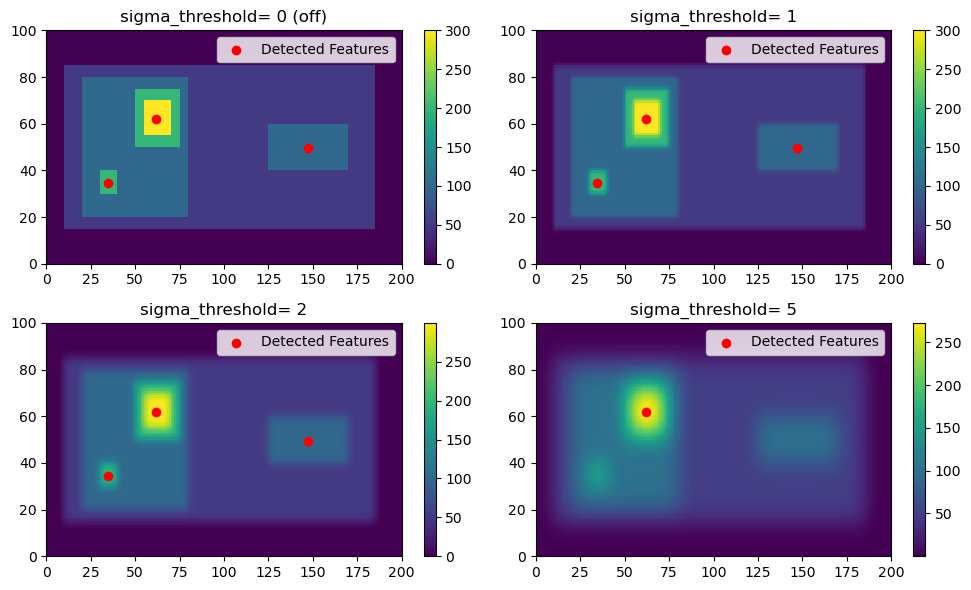

In [4]:
thresholds = [50, 100, 150, 200]
fig, axarr = plt.subplots(2, 2, figsize=(10, 6))
sigma_values = [0, 1, 2, 5]
for sigma_value, ax in zip(sigma_values, axarr.flatten()):
    single_threshold_features = tobac.feature_detection_multithreshold(
        field_in=input_field_da,
        dxy=1000,
        threshold=thresholds,
        target="maximum",
        sigma_threshold=sigma_value,
    )

    # This is what tobac sees
    filtered_field = scipy.ndimage.gaussian_filter(
        input_field_arr[0], sigma=sigma_value
    )
    color_mesh = ax.pcolormesh(filtered_field)
    plt.colorbar(color_mesh, ax=ax)
    # Plot all features detected
    ax.scatter(
        x=single_threshold_features["hdim_2"].values,
        y=single_threshold_features["hdim_1"].values,
        color="r",
        label="Detected Features",
    )
    ax.legend()
    if sigma_value == 0:
        sigma_val_str = "0 (off)"
    else:
        sigma_val_str = "{0}".format(sigma_value)
    ax.set_title("sigma_threshold= " + sigma_val_str)
plt.tight_layout()
plt.show()

***

#### Erosion (`n_erosion_threshold` parameter)
Next, we will explore the use of the erosion filtering by varying the `n_erosion_threshold` parameter in *tobac*. This erosion process only occurrs *after* masking the values greater than the threshold, so it's easiest to see this when detecting on a single threshold. As you can see, increasing the `n_erosion_threshold` parameter reduces the size of each of our features. 

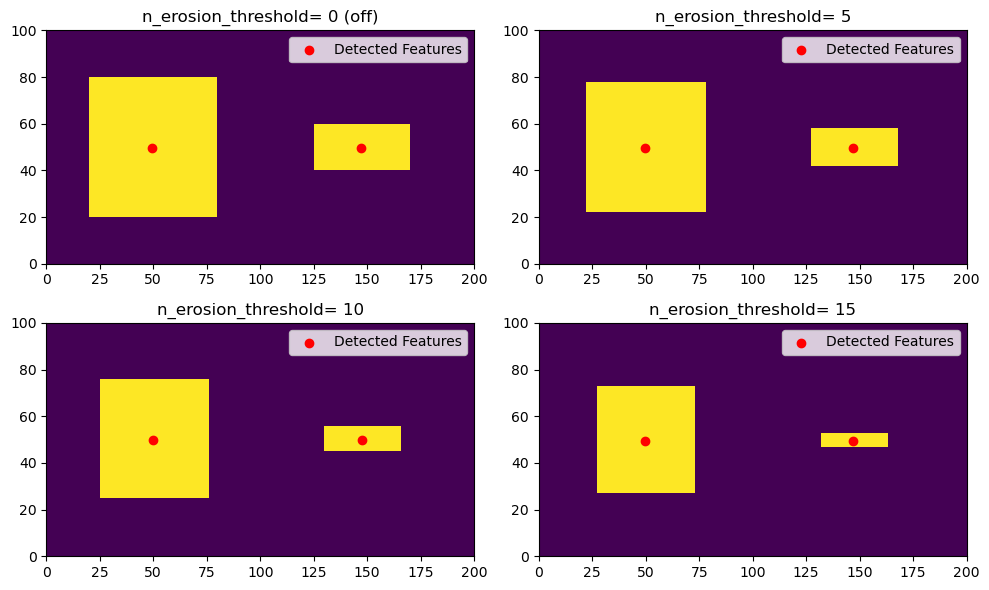

In [5]:
thresholds = [100]
fig, axarr = plt.subplots(2, 2, figsize=(10, 6))
erosion_values = [0, 5, 10, 15]
for erosion, ax in zip(erosion_values, axarr.flatten()):
    single_threshold_features = tobac.feature_detection_multithreshold(
        field_in=input_field_da,
        dxy=1000,
        threshold=thresholds,
        target="maximum",
        n_erosion_threshold=erosion,
    )

    # Create our mask- this is what tobac does internally for each threshold.
    tobac_mask = 1 * (input_field_arr[0] >= thresholds[0])

    if erosion > 0:
        # This is the parameter for erosion that gets passed to the scikit-image library.
        footprint = np.ones((erosion, erosion))
        # This is what tobac sees after erosion.
        filtered_mask = skimage.morphology.binary_erosion(tobac_mask, footprint).astype(
            np.int64
        )
    else:
        filtered_mask = tobac_mask

    color_mesh = ax.pcolormesh(filtered_mask)
    # Plot all features detected
    ax.scatter(
        x=single_threshold_features["hdim_2"].values,
        y=single_threshold_features["hdim_1"].values,
        color="r",
        label="Detected Features",
    )
    ax.legend()
    if erosion == 0:
        sigma_val_str = "0 (off)"
    else:
        sigma_val_str = "{0}".format(erosion)
    ax.set_title("n_erosion_threshold= " + sigma_val_str)
plt.tight_layout()
plt.show()